In [7]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [13]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_d_score_diversion.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(os.path.join(repo_root, lang_path))
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=os.path.join(repo_root, model_dir))

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Search is started.
0- time: 0.27, reward: 0.373917940656397, node: CC(=O)N1CCC[C@H]1NC(=O)c1ccc(C(N)=O)cc1
1- time: 0.57, reward: 0.13806449599534185, node: COc1ccc(C)cc1NC(=O)Nc1ccccc1Cl
2- time: 0.68, reward: 0.3547572232610292, node: CC(=O)N(CCCCO)Cc1cc(N)nc(-c2ccccc2F)c1
3- time: 0.86, reward: 0.0, node: CCC(C)[NH2+][C@@H](C)CC
4- time: 0.95, reward: 0.3595652825512717, node: C[C@H]1CC[C@H](C(=O)NC)C[C@@H]1N(C)COc1ccccc1
5- time: 1.11, reward: 0.13547712537676757, node: C[C@@H]1CN(c2ccc(F)cc2)C[C@H]1C(=O)Nc1ccc2ccccc2c1
6- time: 1.29, reward: 0.2835951704363901, node: N#Cc1ccccc1OCc1ccc(N(C)C2C3C(CC3)C2)cc1
7- time: 1.47, reward: 0.2994962151540378, node: CN(CCC(=O)N1CCCC1)C1CCN(C(=O)NCC2CCCCC2)CC1
8- time: 1.66, reward: 0.0, node: CCOC(=O)[C@@H](N)C(=O)NC[C@H](S)c1ccc(F)c(F)c1
9- time: 1.84, reward: 0.26053143903807396, node: COc1ccc(I)c(NC(=O)c2nc3cc(Br)c(F)cc3o2)c1
10- time: 2.02, reward: 0.354511469044865, node: Cc1csc(-c2cc(Cl)ccn2)c1
11- time: 2.50, reward: 0.2558910881192187

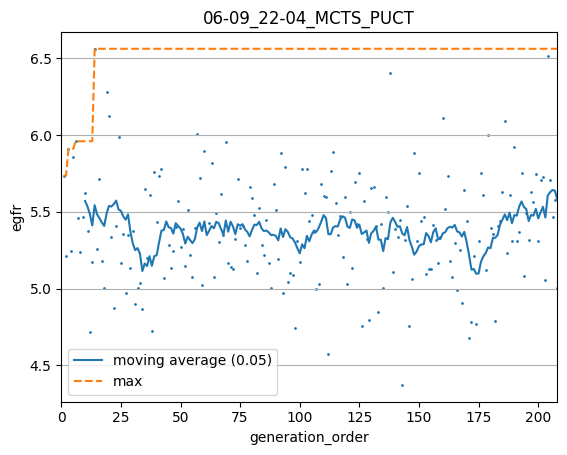

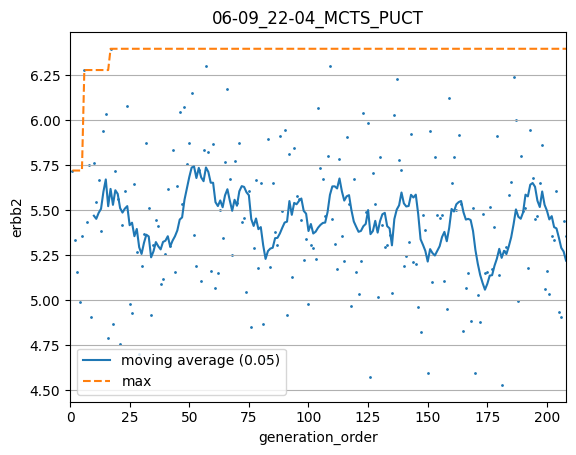

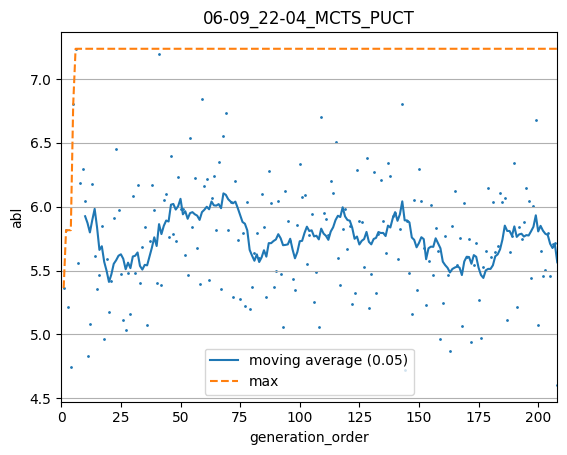

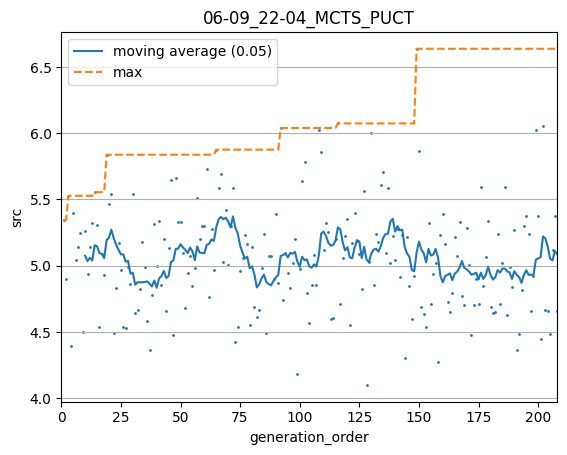

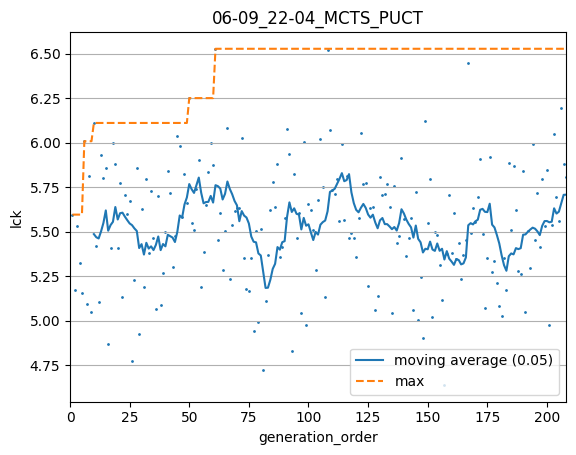

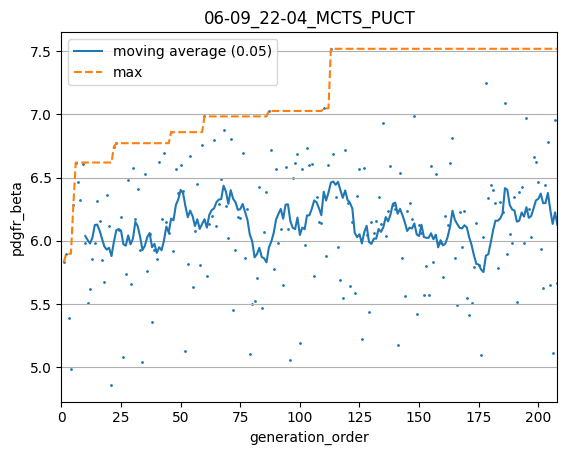

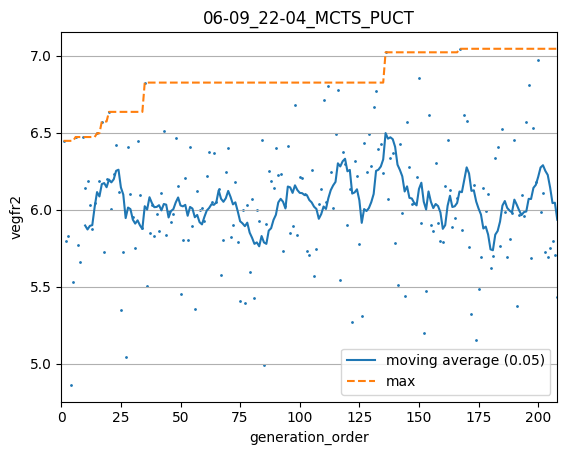

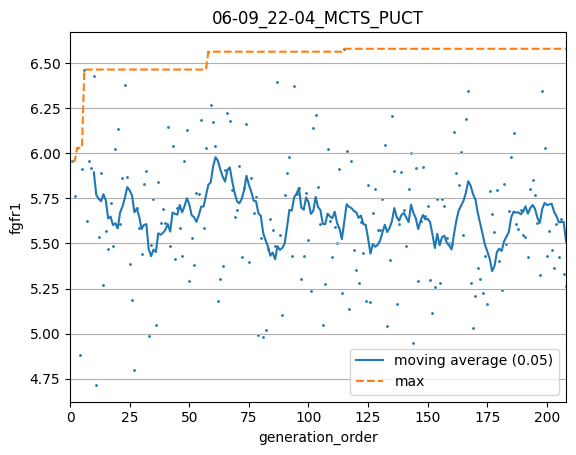

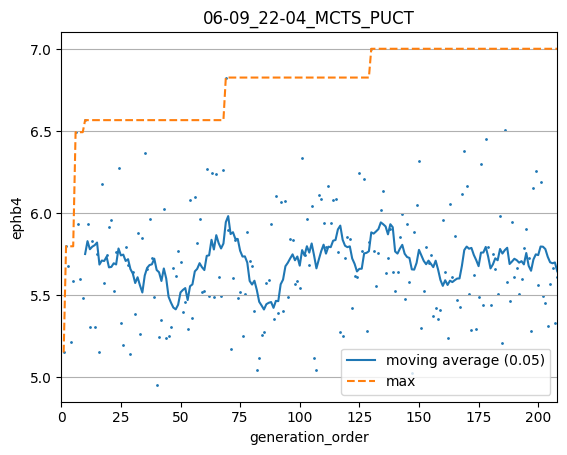

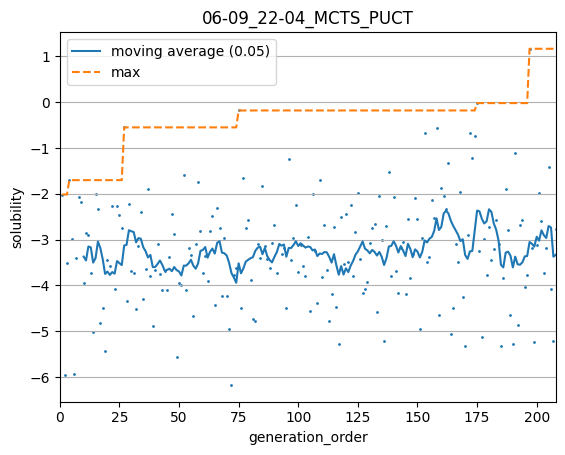

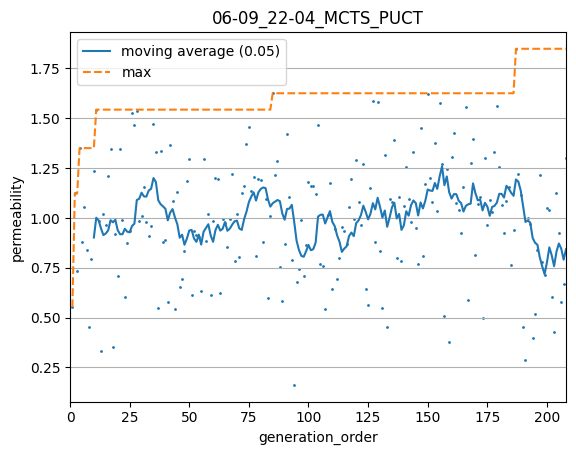

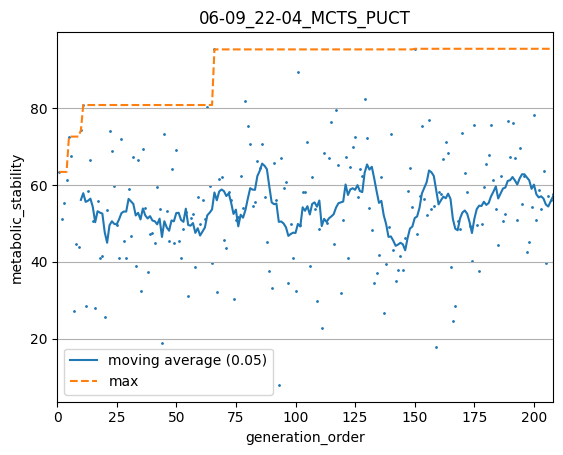

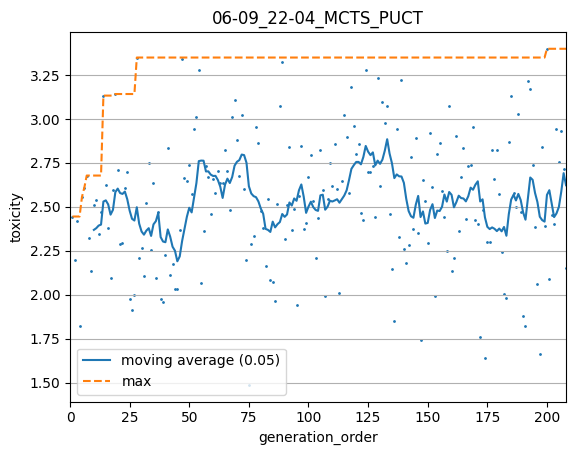

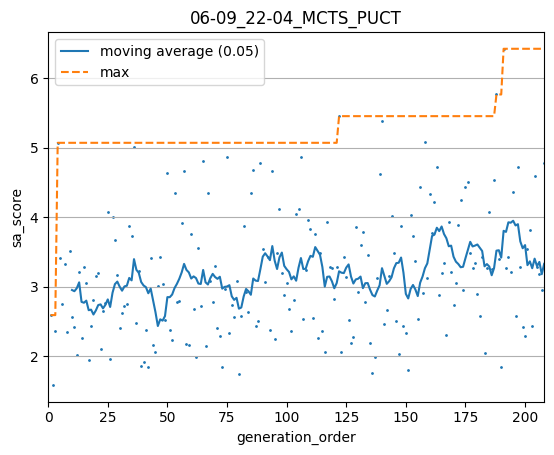

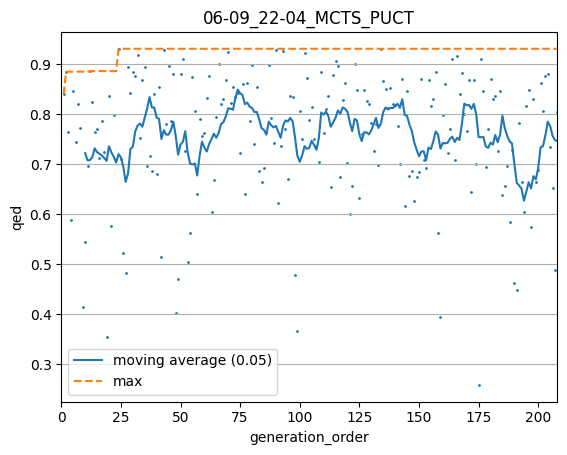

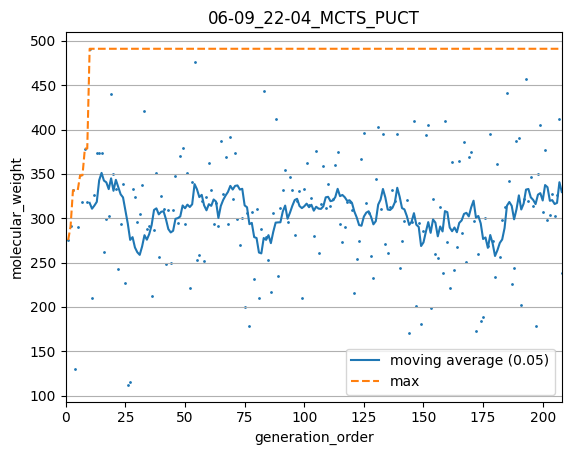

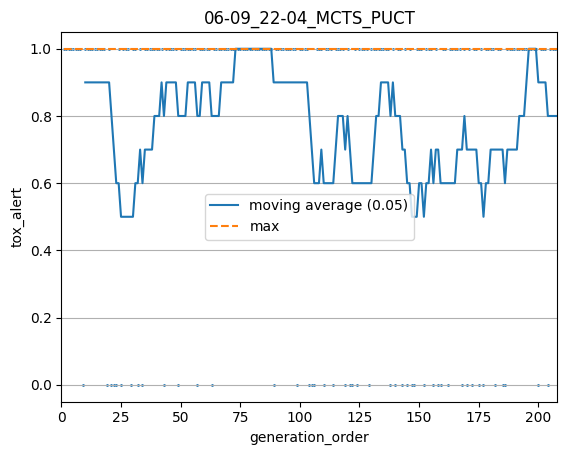

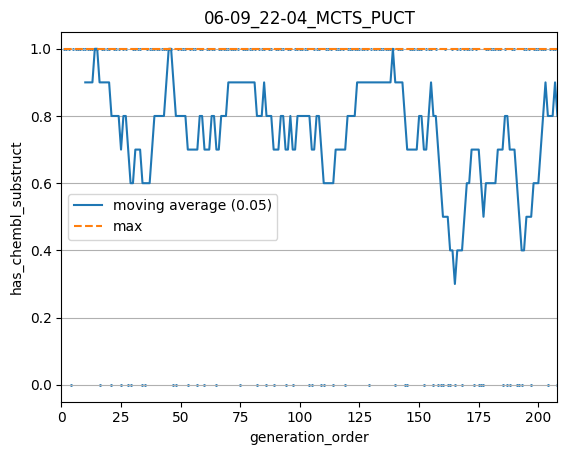

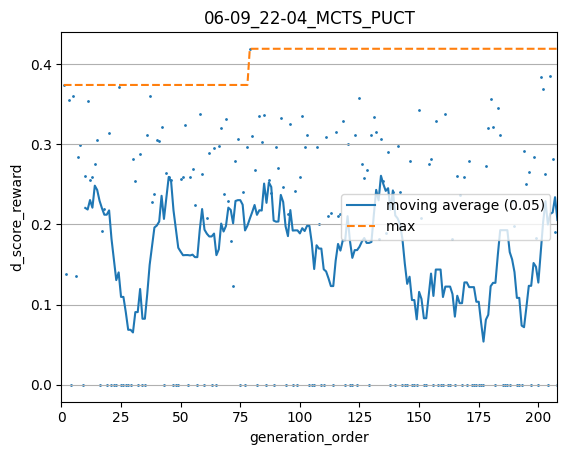

valid rate: 0.5110565110565111
node_per_sec: 3.464754746390854


In [14]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

output_dir, generator_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generator_conf", "filtered_reward"))
generator = MCTS(root=root, transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir, **generator_conf)
src = os.path.join(repo_root, config_path)
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

time_limit, max_generations = (conf.get(k) for k in ("time_limit", "max_generations"))
generator.generate(time_limit=time_limit, max_generations=max_generations)
# cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
# generator.plot_objective_values_and_reward(x_axis = "time")
generator.analyze()

In [12]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [13]:
#load mcts
generator = MCTS.load(save_path, model)